# 1. CIFAR10 Data
* 전체 6만개 데이터
    * train : 50,000
    * test : 10,000

In [48]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print("train dataset shape:", x_train.shape, y_train.shape)
print("test dataset shape:", x_test.shape, y_test.shape)

train dataset shape: (50000, 32, 32, 3) (50000, 1)
test dataset shape: (10000, 32, 32, 3) (10000, 1)


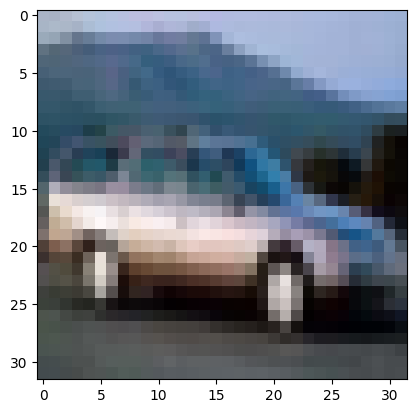

In [49]:
import matplotlib.pyplot as plt

plt.imshow(x_train[4])

### 1.1 Input Image Resize
* AlexNet input size에 맞게 227x227로 resize

In [50]:
import numpy as np
import cv2

# 새로운 이미지 크기
new_size = (227, 227)

# 빈 배열 생성
resized_train_images = np.zeros((x_train.shape[0], new_size[0], new_size[1], 3), dtype=np.uint8)
resized_test_images = np.zeros((x_test.shape[0], new_size[0], new_size[1], 3), dtype=np.uint8)

# x_train (50000, 32, 32, 3) -> (50000, 227, 227, 3)
for i in range(x_train.shape[0]):
    resized_train_images[i] = cv2.resize(x_train[i], new_size)

# x_test (10000, 32, 32, 3) -> (10000, 227, 227, 3)
for i in range(x_test.shape[0]):
    resized_test_images[i] = cv2.resize(x_test[i], new_size)
    

print("train dataset shape:", resized_train_images.shape, y_train.shape)
print("test dataset shape:", resized_test_images.shape, y_test.shape)

train dataset shape: (50000, 227, 227, 3) (50000, 1)
test dataset shape: (10000, 227, 227, 3) (10000, 1)


### 1.2 Label 데이터 One-Hot Encoding 진행
* 정수형 라벨을 그대도 사용할 경우 모델의 Loss Function인 Categorical_crossentropy 부분에서 에러 발생
* 즉, (50000, 1) -> (50000, 10) 형태로 변경 (CIFAR10 데이터의 Class 수는 10개이다.)

In [51]:
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

print("train dataset shape:", resized_train_images.shape, y_train.shape)
print("test dataset shape:", resized_test_images.shape, y_test.shape)

train dataset shape: (50000, 227, 227, 3) (50000, 10)
test dataset shape: (10000, 227, 227, 3) (10000, 10)


# 2. AlexNet Architecture

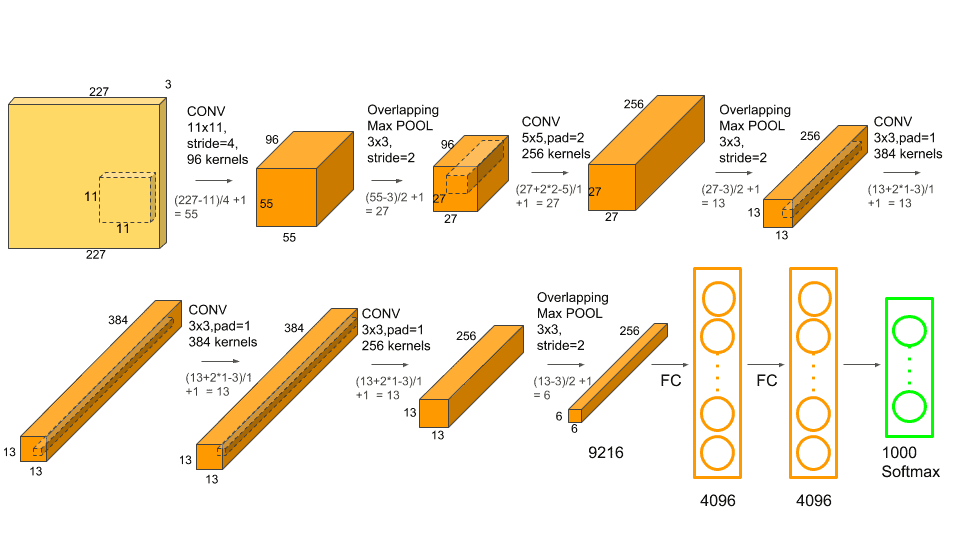
* 합성곱 계층 1
    * 11x11x3 크기의 커널 48개를 2개 그룹 사용하여, 55x55x(48×2) 특징맵 출력 (stride=4, padding=0)
    * 3×3 중첩 최대풀링 <span style="color: #2D3748; background-color:#fff5b1;"> Overlapping Max Pooling</span> 을 적용하여, 27x27x(48×2) 특징맵 출력 (stride=2)
    * 지역 응답 정규화 <span style="color: #2D3748; background-color:#fff5b1;">Local Response Normalization</span> 를 적용하고, 27x27x(48×2) 특징맵을 출력



* 합성곱 계층 2
    * 5x5x48 크기의 커널 128개를 2개 그룹 사용하여, 27x27x(128×2) 특징맵 출력 (stride=1, padding=2)
    * 3×3 중첩 최대풀링 적용하여, 13x13x128x2 특징맵 출력 (stride=2)
    * 지역 응답 정규화를 적용하고, 13x13x128x2 특징맵 출력



* 합성곱 계층 3
    * 3x3x256 크기의 커널 192개를 2개 그룹 사용하여, 13x13x192x2 특징맵 출력 (stride=1, padding=1)



* 합성곱 계층 4
    * 3x3x192 크기의 커널 192개를 2개 그룹 사용하여, 13x13x192x2 특징맵 출력 (stride=1, padding=1)



* 합성곱 계층 5
    * 3x3x192 크기의 커널 128개를 2개 그룹 사용하여, 13x13x128x2 특징맵 출력 (stride=1, padding=1)
    * 3×3 중첩 최대풀링(stride=2)을 적용하여, 6x6x128x2 특징맵 출력



* <span style="color: #2D3748; background-color:#fff5b1;">완전연결 계층</span> 6-8
    * 5계층 합성곱 후 6계층, 7계층에서는 각각 4096개의 노드가 있습니다.
    * 마지막 8계층에는 1000개의 노드가 있어 1000개 클래스 구분을 의미하는 확률값을 출력합니다.
    * 하지만 지금은 CIFAR10 데이터를 학습하니 마지막 Dense Layer에 클래스 수를 1000개에서 10개로 변경했습니다.



* 파라미터 수와 계산 복잡도
    * AlexNet에는 약 6천만 개의 학습 가능한 파라미터가 있습니다. 
    * 당시 GPU 환경에서 5~6일이 걸렸던 대규모 모델입니다.

In [52]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback, TensorBoard
# from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
from sklearn.preprocessing import LabelBinarizer
from tensorflow.nn import local_response_normalization  # lrn     

In [55]:
# modeling(functional API)
input_shape = (227, 227, 3)  # 논문에서 제시된 shape (224,224) -> 추후 수정된 shape (227x227)
x = Input(shape = input_shape, name='INPUT')

# CONV
conv1 = Conv2D(filters=96, kernel_size=11, activation='relu', strides=4, name='CONV_1')(x)
pool1 = MaxPooling2D((3,3), strides=2, name='POOL_1')(conv1)  # overlapped pooling
# lrn1 = local_response_normalization(conv1,depth_radius=5, bias=2, alpha=0.0001, beta=0.75) 
lrn1 = BatchNormalization(name='LRN_1')(pool1)

conv2 = Conv2D(filters=256, kernel_size=5, activation='relu', strides=1, padding='same', name='CONV_2')(lrn1)
pool2 = MaxPooling2D((3,3), strides=2, name='POOL_2')(conv2)
# lrn2 = local_response_normalization(conv2,depth_radius=5, bias=2,  alpha=0.0001, beta=0.75)
lrn2 = BatchNormalization(name='LRN_2')(pool2)

conv3 = Conv2D(filters=384, kernel_size=3, activation='relu', strides=1, padding='same', name='CONV_3')(lrn2)
conv4 = Conv2D(filters=384, kernel_size=3, activation='relu', strides=1, padding='same', name='CONV_4')(conv3)
conv5 = Conv2D(filters=256, kernel_size=3, activation='relu', strides=1, padding='same', name='CONV_5')(conv4)
pool3 = MaxPooling2D((3,3), strides=2, name='POOL_3')(conv5)

# FC
f = Flatten()(pool3)
f = Dense(4096, activation='relu', name='FC_1')(f)
f = Dropout(0.5)(f)  # 논문 parameter 0.5 이용
f = Dense(4096, activation='relu', name='FC_2')(f)
f = Dropout(0.5)(f)
out = Dense(10, activation='softmax', name='OUTPUT')(f)

model = Model(inputs=x, outputs=out)
model.summary()
     

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (InputLayer)          [(None, 227, 227, 3)]     0         
                                                                 
 CONV_1 (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 POOL_1 (MaxPooling2D)       (None, 27, 27, 96)        0         
                                                                 
 LRN_1 (BatchNormalization)  (None, 27, 27, 96)        384       
                                                                 
 CONV_2 (Conv2D)             (None, 27, 27, 256)       614656    
                                                                 
 POOL_2 (MaxPooling2D)       (None, 13, 13, 256)       0         
                                                                 
 LRN_2 (BatchNormalization)  (None, 13, 13, 256)       1024

### 2.1 CIFAR10 image size (32x32) -> (227x227) 변경 후 AlexNet 적용
* AlexNet 모델의 기존 input image size를 고정하기 위해 CIFAR10 데이터의 Shape를 강제로 32x32에서 227x227로 바꿨는데 전혀 학습되고 있지 않습니다.
* CIFAR10 Shape는 유지하고 AlexNet의 Input image size를 CIFAR10 데이터에 맞추어 학습 진행해보겠습니다.

In [56]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

history = model.fit(resized_train_images, y_train,
                    batch_size=128,
                    epochs=10, 
                    verbose=1,
                    validation_data=(resized_test_images, y_test))

Epoch 1/10


2024-10-10 10:33:54.258827: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8600
2024-10-10 10:33:55.285482: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


391/391 [==============================] - 35s 76ms/step - loss: 2.3940 - accuracy: 0.0984 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 2/10
391/391 [==============================] - 26s 66ms/step - loss: 2.3028 - accuracy: 0.0981 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 3/10
391/391 [==============================] - 23s 59ms/step - loss: 2.3028 - accuracy: 0.0998 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 4/10
391/391 [==============================] - 20s 52ms/step - loss: 2.3028 - accuracy: 0.0979 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 5/10
391/391 [==============================] - 19s 48ms/step - loss: 2.3028 - accuracy: 0.0982 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 6/10
391/391 [==============================] - 15s 38ms/step - loss: 2.3027 - accuracy: 0.0980 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 7/10
391/391 [==============================] - 24s 61ms/step - loss: 2.3027 - accuracy: 0.0975 - val_loss: 2.3026 - val_accuracy: 0.1000
Epo

### 2.2 CIFAR10 image size 유지하고 AlexNet의 Input image size를 줄임.
* 픽셀 값이 0 ~ 255인 이미지 데이터를 0 ~ 1 사이로 스케일링 진행했습니다.
* 위의 모델보다 학습이 잘 된 val_accuracy : 0.7209 결과 확인

In [69]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()


# 이미지 데이터 정규화 (픽셀 값 0~255를 0~1로 스케일링)
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

print("train dataset shape:", x_train.shape, y_train.shape)
print("test dataset shape:", x_test.shape, y_test.shape)

train dataset shape: (50000, 32, 32, 3) (50000, 1)
test dataset shape: (10000, 32, 32, 3) (10000, 1)


In [70]:
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

print("train dataset shape:", resized_train_images.shape, y_train.shape)
print("test dataset shape:", resized_test_images.shape, y_test.shape)

train dataset shape: (50000, 227, 227, 3) (50000, 10)
test dataset shape: (10000, 227, 227, 3) (10000, 10)


In [71]:
batch_size = 128
num_classes = 10
epochs = 10

model = Sequential()
# model.add(Conv2D(96, (11,11), strides=(4,4), activation='relu', padding='same', input_shape=(img_height, img_width, channel,)))
# for original Alexnet
model.add(Conv2D(48, (3,3), strides=(2,2), activation='relu', padding='same', input_shape=(32, 32, 3,)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
# Local Response normalization for Original Alexnet
model.add(BatchNormalization())

model.add(Conv2D(96, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2)))
# Local Response normalization for Original Alexnet
model.add(BatchNormalization())

model.add(Conv2D(192, (3,3), activation='relu', padding='same'))
model.add(Conv2D(192, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2)))
# Local Response normalization for Original Alexnet
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 16, 16, 48)        1344      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 8, 8, 48)         0         
 g2D)                                                            
                                                                 
 batch_normalization_12 (Bat  (None, 8, 8, 48)         192       
 chNormalization)                                                
                                                                 
 conv2d_21 (Conv2D)          (None, 8, 8, 96)          41568     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 3, 3, 96)         0         
 g2D)                                                            
                                                      

In [72]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=10, 
                    verbose=1,
                    validation_data=(x_test, y_test))

Epoch 1/10
391/391 [==============================] - 8s 18ms/step - loss: 1.5571 - accuracy: 0.4526 - val_loss: 4.0869 - val_accuracy: 0.1412
Epoch 2/10
391/391 [==============================] - 6s 15ms/step - loss: 1.1003 - accuracy: 0.6153 - val_loss: 1.3472 - val_accuracy: 0.5488
Epoch 3/10
391/391 [==============================] - 7s 17ms/step - loss: 0.9085 - accuracy: 0.6879 - val_loss: 0.9838 - val_accuracy: 0.6715
Epoch 4/10
391/391 [==============================] - 7s 18ms/step - loss: 0.7807 - accuracy: 0.7326 - val_loss: 0.9606 - val_accuracy: 0.6827
Epoch 5/10
391/391 [==============================] - 6s 16ms/step - loss: 0.6848 - accuracy: 0.7683 - val_loss: 1.0010 - val_accuracy: 0.6802
Epoch 6/10
391/391 [==============================] - 6s 16ms/step - loss: 0.5897 - accuracy: 0.8020 - val_loss: 0.9379 - val_accuracy: 0.7049
Epoch 7/10
391/391 [==============================] - 7s 17ms/step - loss: 0.5119 - accuracy: 0.8284 - val_loss: 1.0494 - val_accuracy: 0.6780

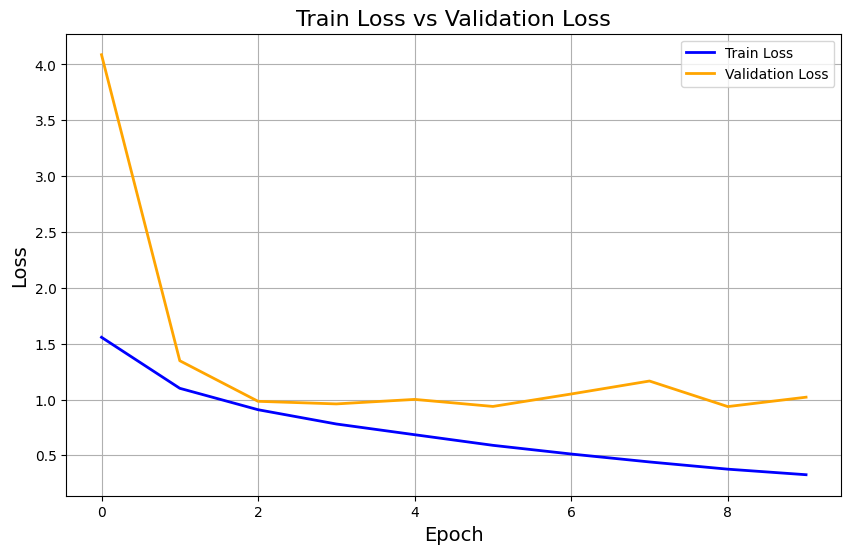

In [73]:
import matplotlib.pyplot as plt

# 모델 학습 후 반환된 history 객체를 사용하여 학습 손실(loss) 및 검증 손실(val_loss)을 시각화
def plot_loss(history):
    plt.figure(figsize=(10, 6))

    # Train Loss
    plt.plot(history.history['loss'], label='Train Loss', color='blue', linewidth=2)
    # Validation Loss
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linewidth=2)

    # 그래프 제목 및 라벨 설정
    plt.title('Train Loss vs Validation Loss', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)

    # 범례 표시
    plt.legend(loc='upper right')

    # 그래프 출력
    plt.grid(True)
    plt.show()

# 위에서 학습한 모델의 history 객체를 전달
plot_loss(history)


In [74]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
predictions = model.predict(x_test, verbose=1)

313/313 [==============================] - 4s 11ms/step - loss: 1.0206 - accuracy: 0.7207
Test loss: 1.0206462144851685
Test accuracy: 0.7207000255584717
313/313 [==============================] - 1s 3ms/step


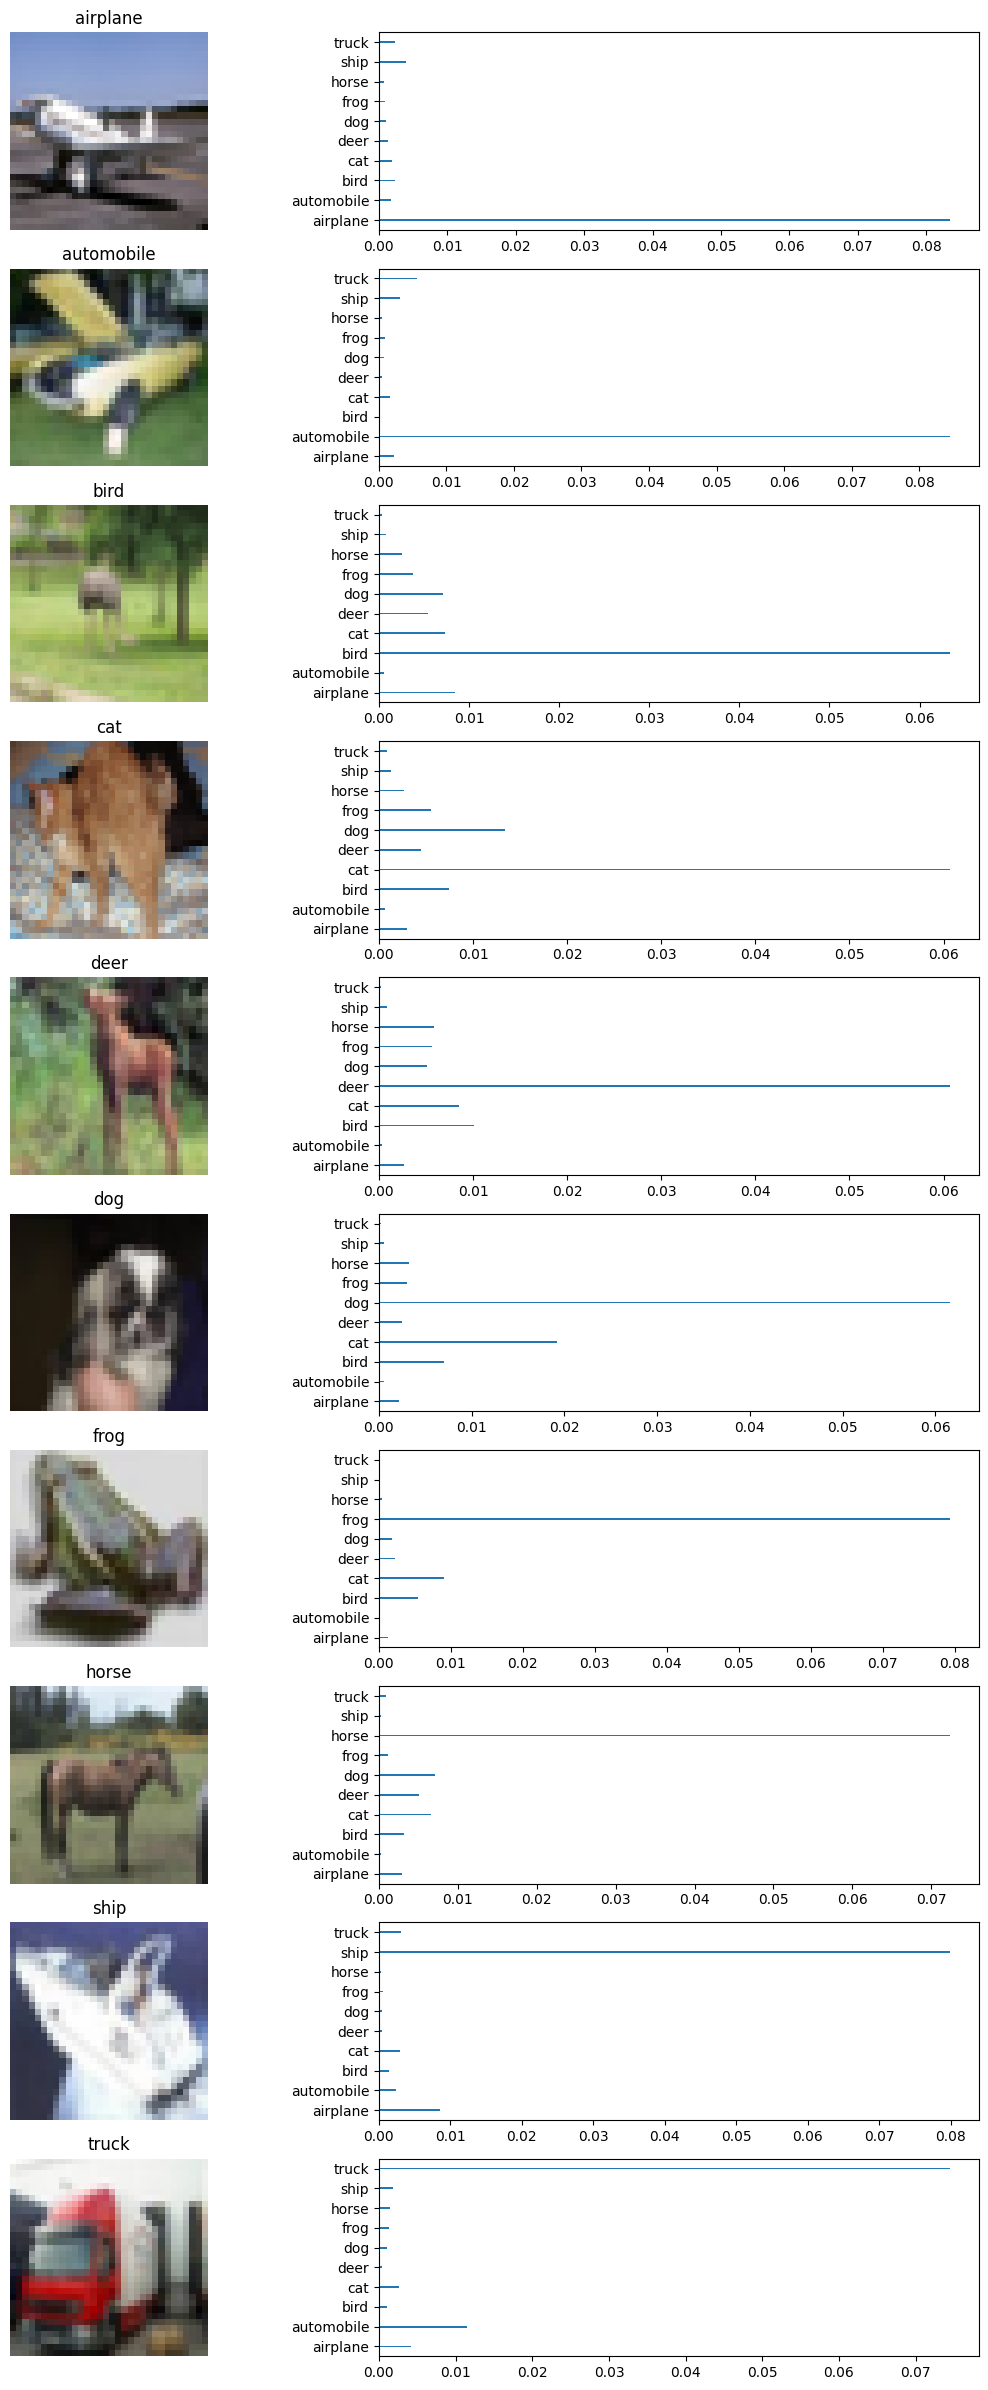

In [75]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def display_image_predictions(features, labels, predictions):
    n_classes = 10
    label_names = load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axs = plt.subplots(10, 2, figsize=(12,24))
    margin = 0.05
    ind = np.arange(n_classes)
    width = (1. - 2. * margin) / n_classes    
    arr_features = [None]*10
    arr_predictions = np.zeros((10, 10))
    last_image_i = 0
    
    for i, prediction in enumerate(predictions):
        label_id = label_ids[i]
        feature = features[i]
        arr_features[label_id] = feature
        max_id = np.argmax(prediction)
        arr_predictions[label_id][max_id] += 1
        last_image_i = i

    arr_predictions /= last_image_i
    
    for i in range(10):
      feature = arr_features[i]
      pred_name = label_names[i]
      prediction = arr_predictions[i]
      axs[i][0].imshow(feature)
      axs[i][0].set_title(pred_name)
      axs[i][0].set_axis_off()

      axs[i][1].barh(ind + margin, prediction, width)
      axs[i][1].set_yticks(ind + margin)
      axs[i][1].set_yticklabels(label_names)

    plt.tight_layout()

display_image_predictions(x_test, y_test, predictions)

# Reference
* https://bskyvision.com/421 -> AlexNet 설명
* https://github.com/daeunni/CNN_PyTorch-codes/blob/main/AlexNet(2012).ipynb -> 코드 참고